In [1]:
# загружаем библиотеки
import os
import time
import glob
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [ ]:
# подключаем свой Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка и подготовка данных

In [ ]:
# загрузим датасет со своего Google Drive
# предварительно скачиваем датасет с kaggle: https://www.kaggle.com/datasets/lsind18/gemstones-images
!mkdir -p data

!cp drive/MyDrive/jewels/test.zip data/
!cp drive/MyDrive/jewels/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/



In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/train"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 1999
Изображений в val: 857


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(
                    (224, 224), scale=(0.8, 1), ratio=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))


Количество классов в train:  87
Количество классов в val:  87
Количество классов одинаково:  True


In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
val_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# Вывод изображений и их меток на печать для предварительного просмотра
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=3, ncols=3, figsize=(8, 8),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=800)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((2, 1, 0)))

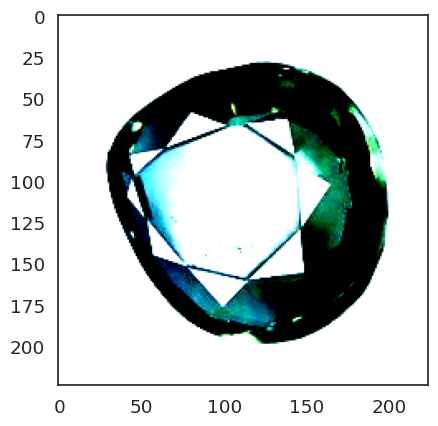

Alexandrite


In [ ]:
image,label = train_dataset[20]
plt.imshow(image.permute(2,1,0))
plt.show()
print(train_dataset.classes[label])

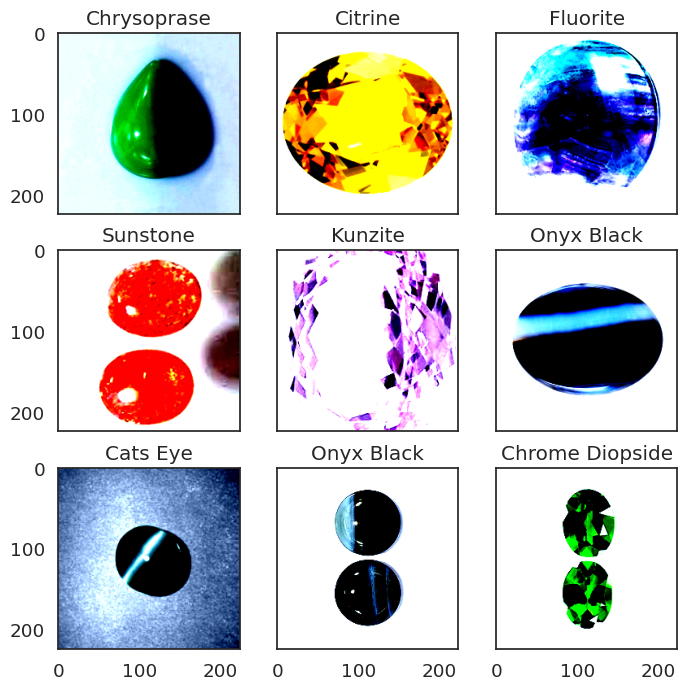

In [ ]:
show_images(val_dataset)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Визуализация графиков обучения модели

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

# Обучение модели

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    scheduler,
    num_epochs
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()



            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        scheduler.step()

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 1. Модель RESNET18

In [ ]:
from torchvision.models import resnet18

## 1.1 Модель RESNET18 с нуля

Epoch 300 of 300 took 22.275s
  training loss (in-iteration): 	0.997294
  validation loss (in-iteration): 	1.459493
  training accuracy: 			72.20 %
  validation accuracy: 			58.79 %


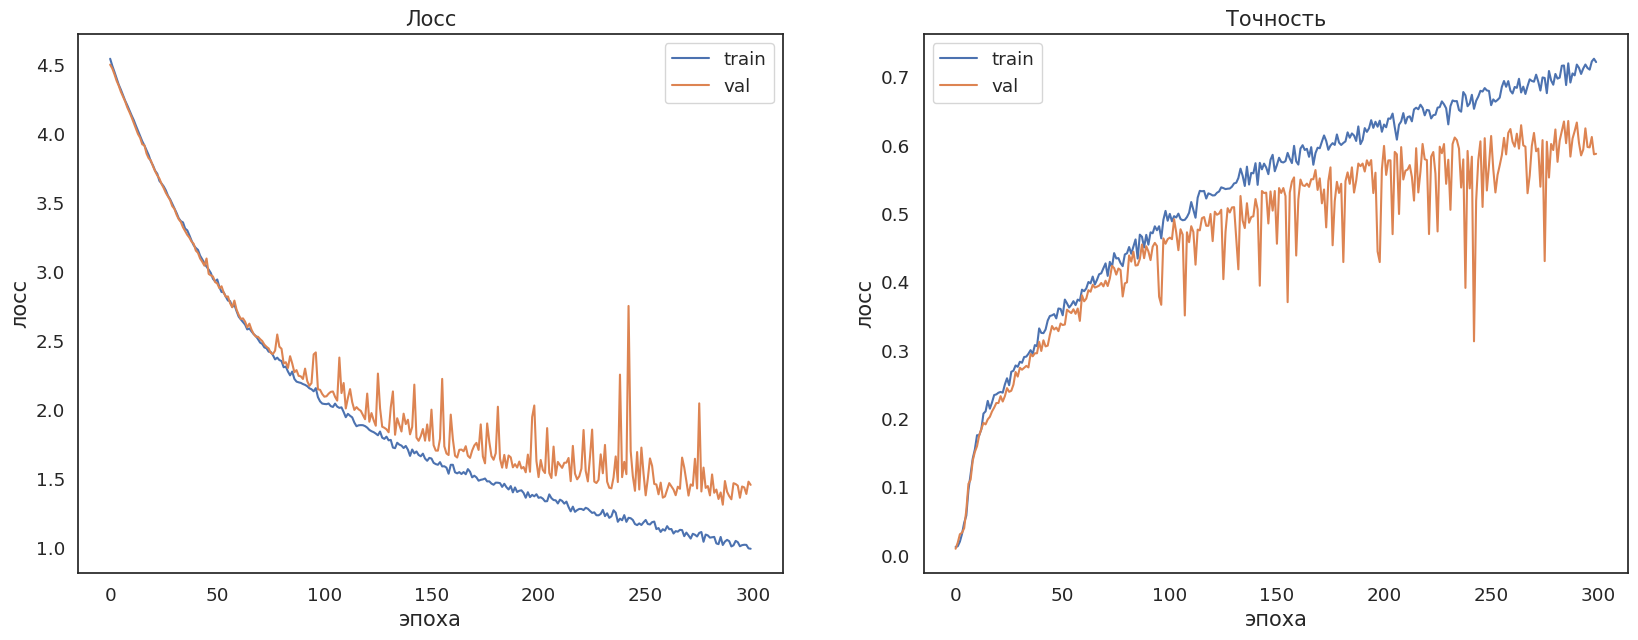

In [ ]:
# возьмем модель resnet18 с 0
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 87)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=300
)


## 1.2 Предобученная модель RESNET18

Epoch 50 of 50 took 14.665s
  training loss (in-iteration): 	0.759496
  validation loss (in-iteration): 	1.220908
  training accuracy: 			88.61 %
  validation accuracy: 			69.94 %


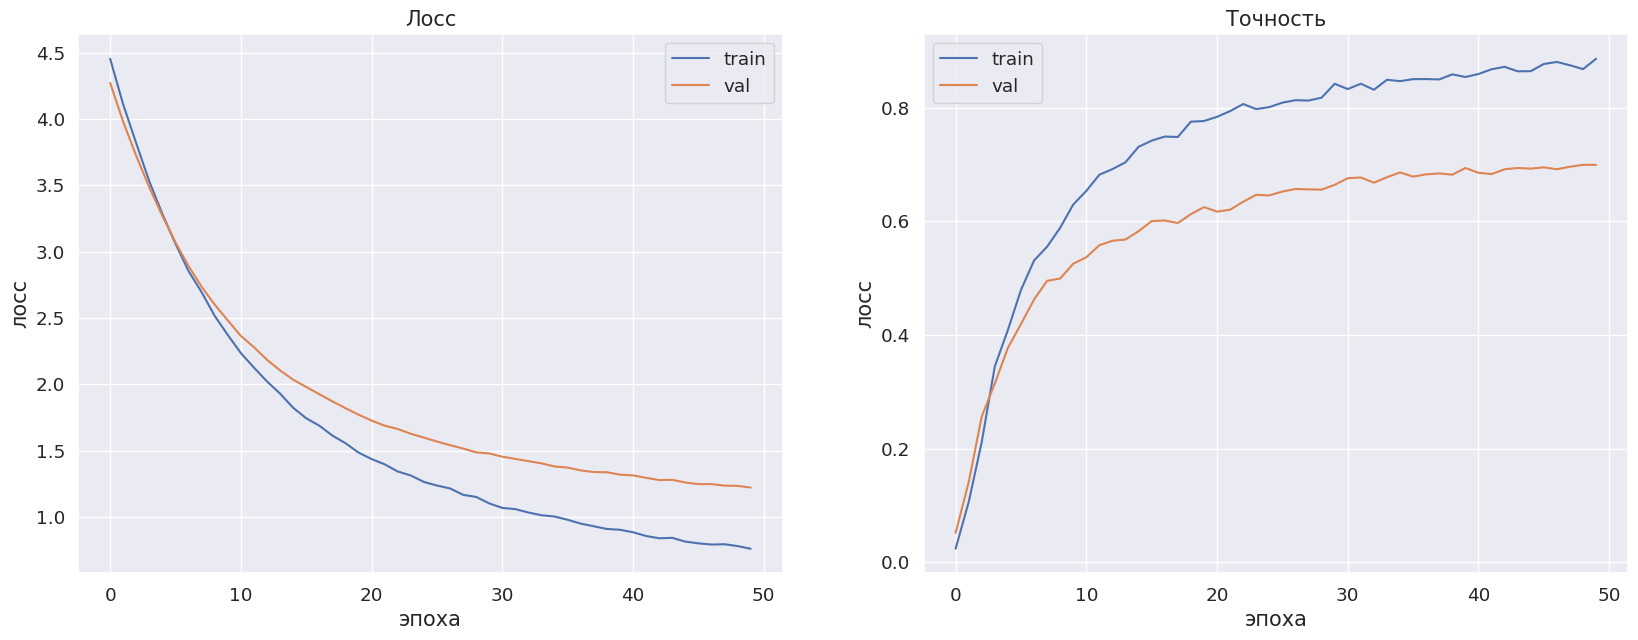

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 87)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=50
)

## 1.3 Предобученная модель RESNET18 с добавленными слоями классификации

Epoch 50 of 50 took 21.401s
  training loss (in-iteration): 	0.022071
  validation loss (in-iteration): 	0.928460
  training accuracy: 			99.80 %
  validation accuracy: 			75.48 %


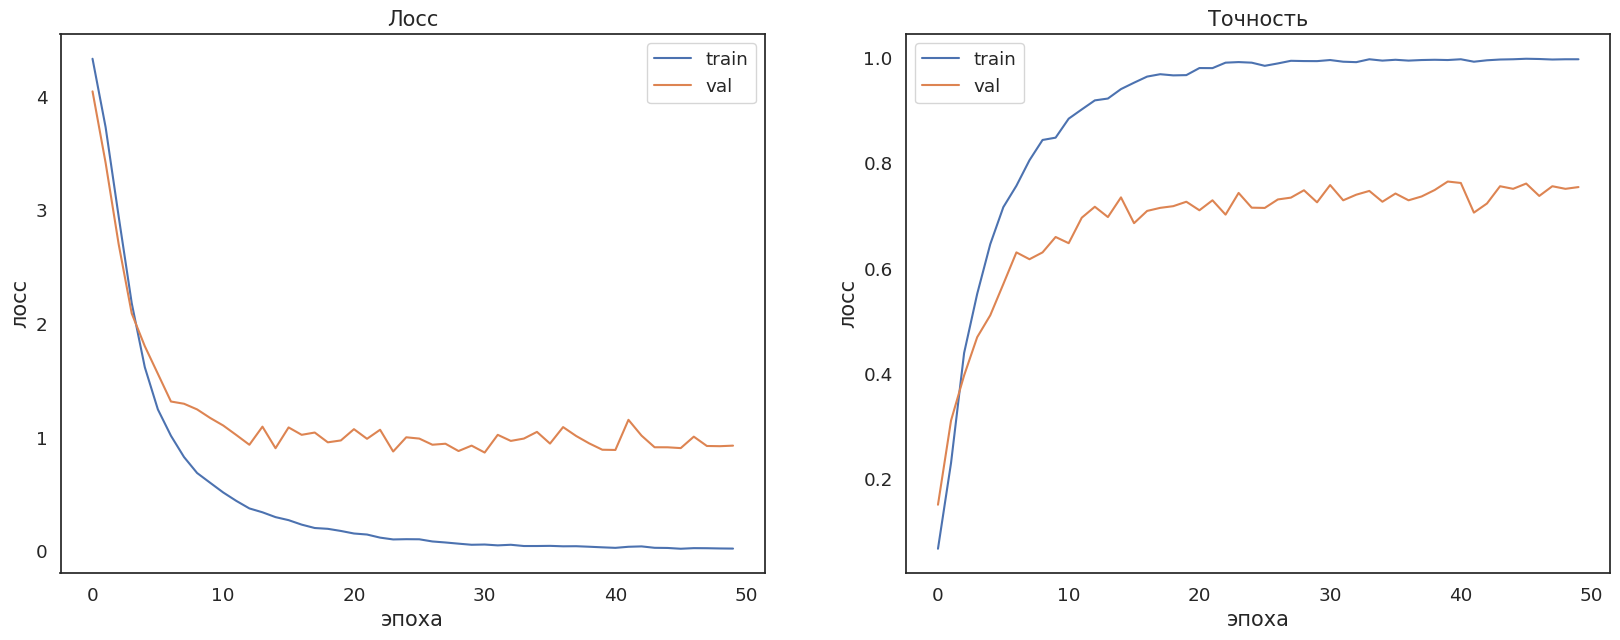

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 87))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=50
)

## 1.4 Предобученная сеть RESNET18 c добавлением scheduler StepLR

Epoch 30 of 30 took 13.448s
  training loss (in-iteration): 	0.433123
  validation loss (in-iteration): 	0.975307
  training accuracy: 			93.72 %
  validation accuracy: 			71.97 %


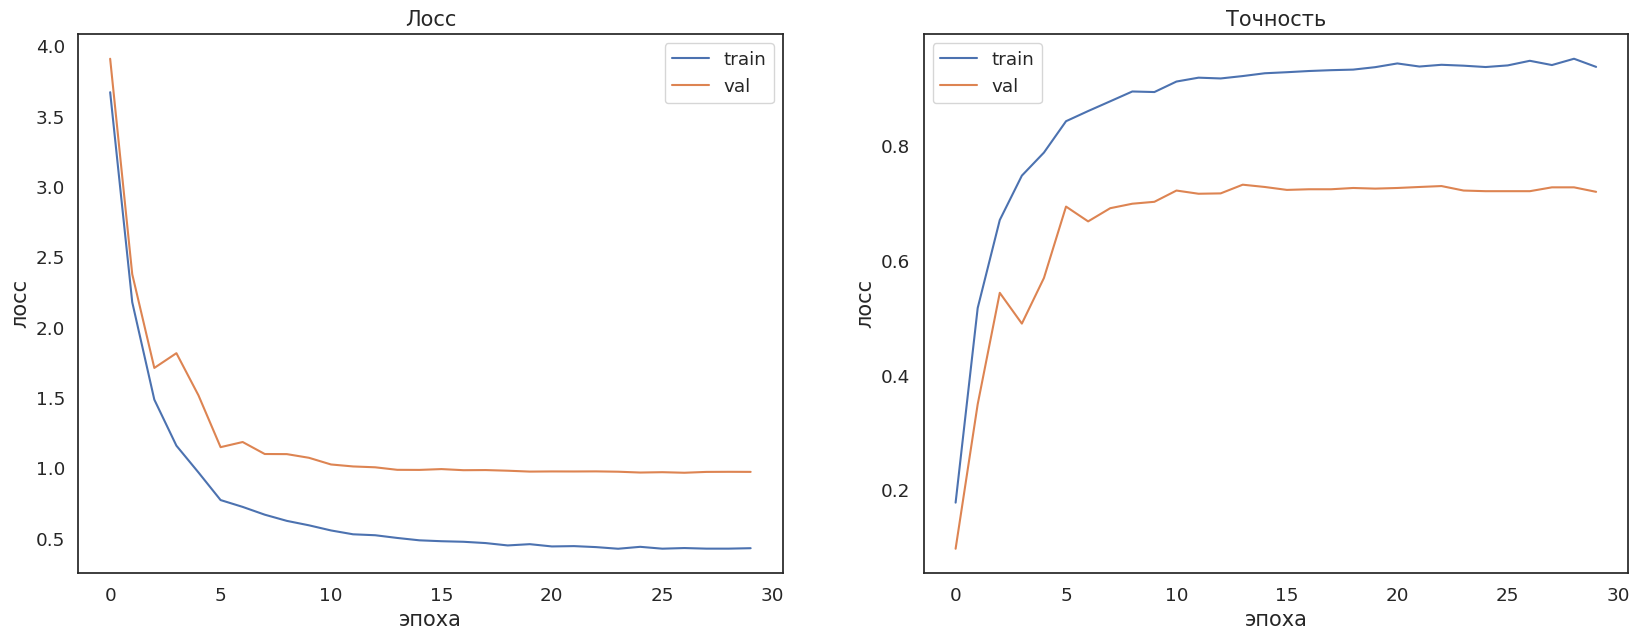

In [ ]:
# возьмём предобученную сеть
fe_model_sched = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model_sched.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model_sched.fc = nn.Linear(512, 87)
fe_model_sched = fe_model_sched.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model_sched.parameters(), lr=0.1)

# добавим scheduler StepLR для пошагового снижения скорости обучения
scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

clf_model, history = train(
    fe_model_sched, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=30
)


## 1.5 Предобученная модель RESNET18 с добавленными слоями классификации и scheduler ExponentialLR

Epoch 30 of 30 took 16.942s
  training loss (in-iteration): 	0.011001
  validation loss (in-iteration): 	0.720138
  training accuracy: 			99.90 %
  validation accuracy: 			80.59 %


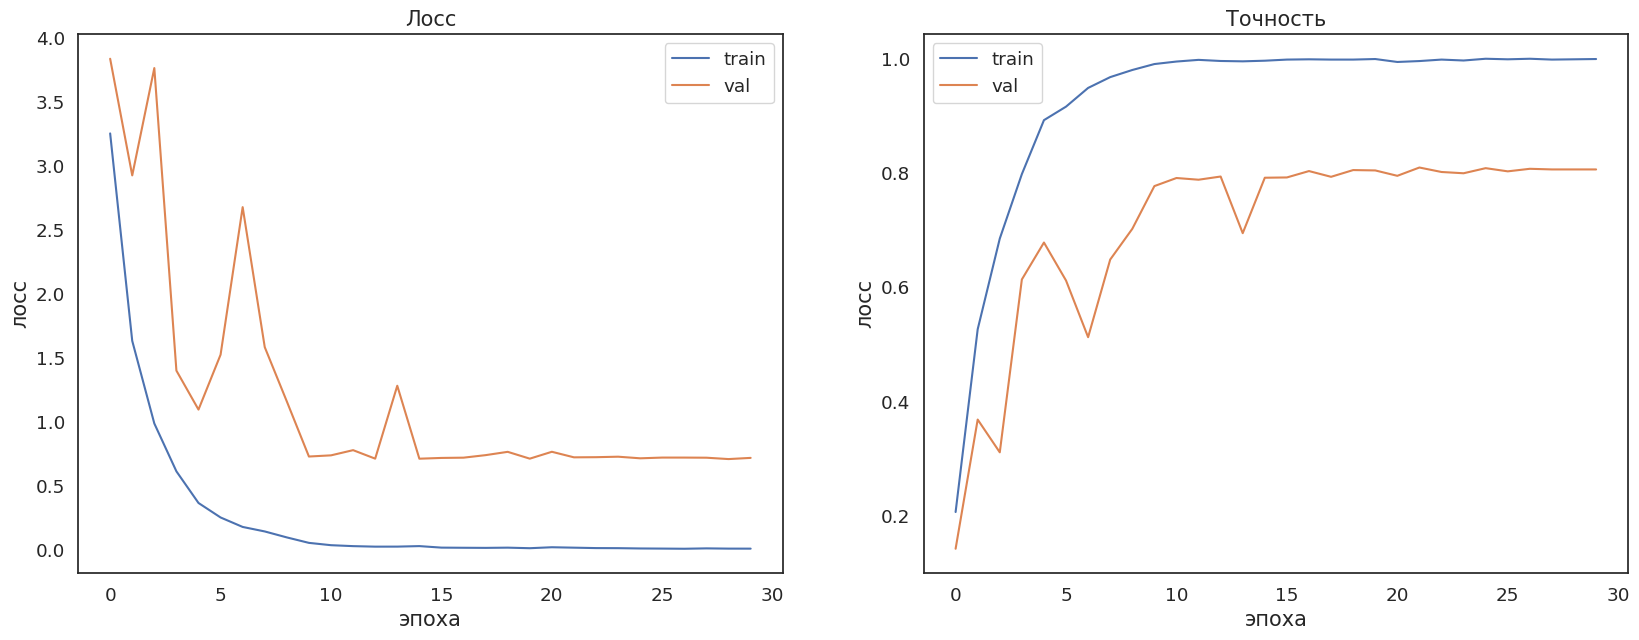

In [ ]:
fine_tuning_model_sched = nn.Sequential()

fine_tuning_model_sched.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model_sched.add_module('relu_1', nn.ReLU())
fine_tuning_model_sched.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model_sched.add_module('relu_2', nn.ReLU())
fine_tuning_model_sched.add_module('fc_2', nn.Linear(512, 87))

fine_tuning_model_sched = fine_tuning_model_sched.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model_sched.parameters(), lr=0.1)

# добавим scheduler ExponentialLR для уменьшения скорости обучения каждой группы параметров на гамму в каждую эпоху
scheduler = ExponentialLR(optimizer,
                          gamma = 0.9)

clf_model, history = train(
    fine_tuning_model_sched, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=30
)

In [ ]:
torch.cuda.empty_cache()

# 2. Модель VGG16

In [ ]:
from torchvision.models import vgg16

## 2.1 Модель VGG16 с нуля

Epoch 50 of 50 took 46.809s
  training loss (in-iteration): 	0.112634
  validation loss (in-iteration): 	2.382517
  training accuracy: 			96.63 %
  validation accuracy: 			57.75 %


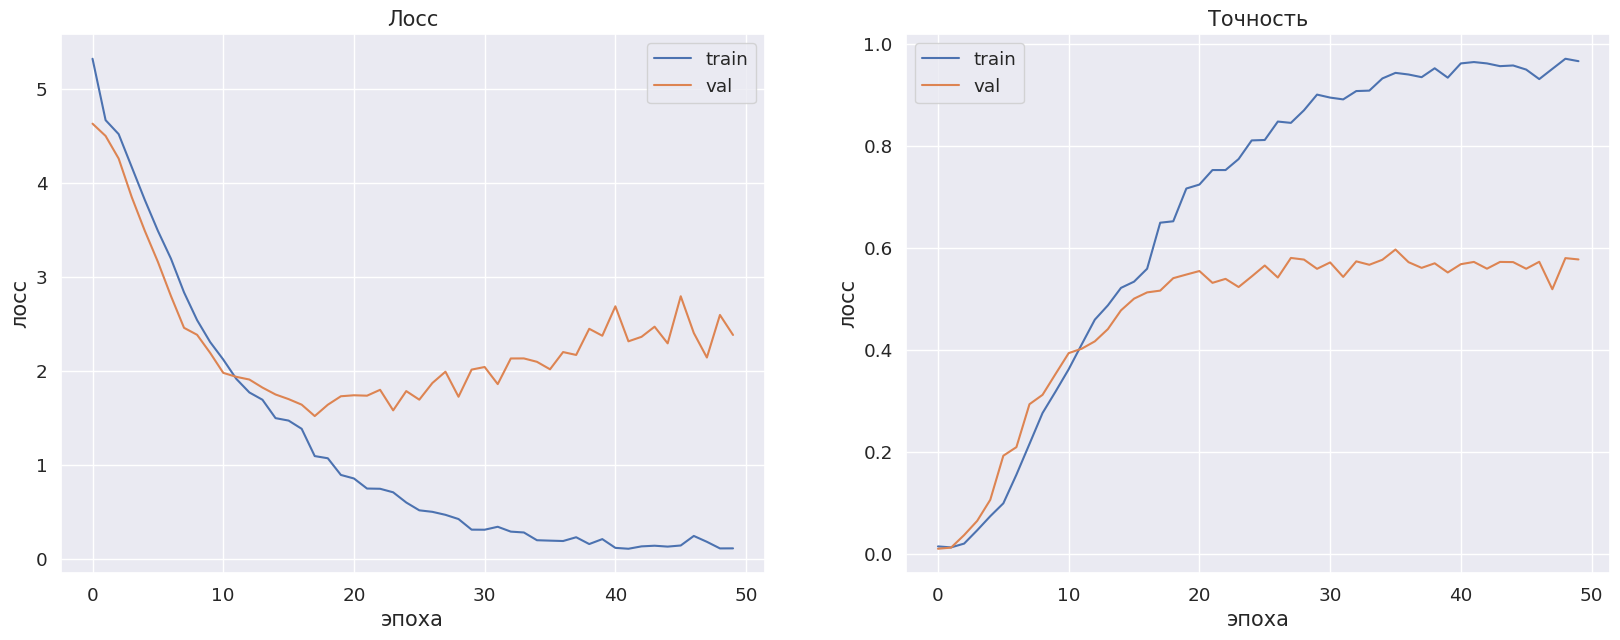

In [ ]:
# возьмем модель vgg16 с 0
model_2 = vgg16(pretrained=False)
model_2.fc = nn.Linear(4096, 87)
model_2 = model_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)

clf_model, history = train(
    model_2, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=50
)


## 2.2 Предобученная модель VGG16

Epoch 50 of 50 took 26.833s
  training loss (in-iteration): 	0.177789
  validation loss (in-iteration): 	1.201415
  training accuracy: 			95.95 %
  validation accuracy: 			66.02 %


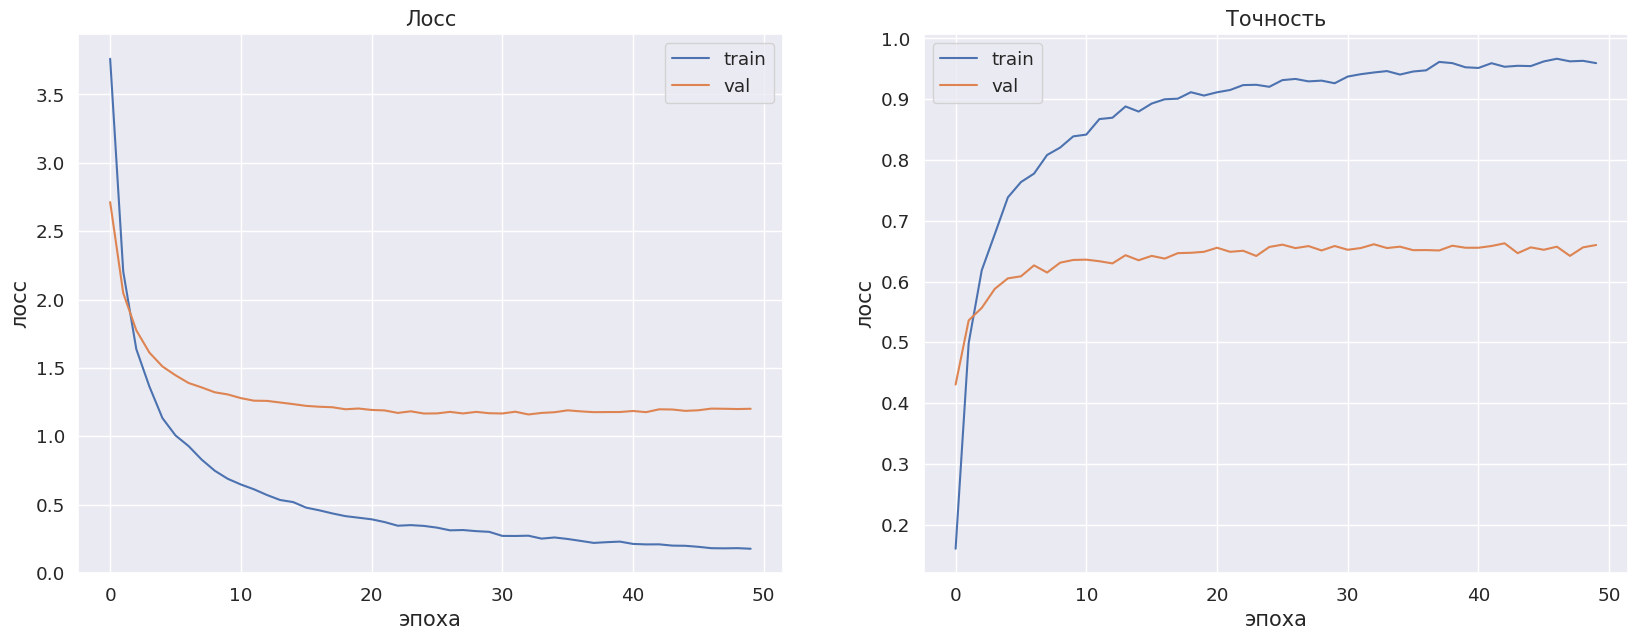

In [ ]:
# возьмём предобученную сеть
fe_model_2 = vgg16(pretrained=True).to(device)

# заморозим все слои сети
for param in fe_model_2.parameters():
    param.requires_grad = False
# добавим над feature extractor сетью классификационный слой
fe_model_2.classifier
fe_model_2.classifier[6] = nn.Linear(in_features=4096, out_features=87).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fe_model_2.parameters(), lr=0.0005)

clf_model, history = train(
    fe_model_2, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=50
)

## 2.3 Предобученная модель VGG16 с добавленными слоями классификации

Epoch 50 of 50 took 47.427s
  training loss (in-iteration): 	0.023167
  validation loss (in-iteration): 	1.302086
  training accuracy: 			99.16 %
  validation accuracy: 			76.77 %


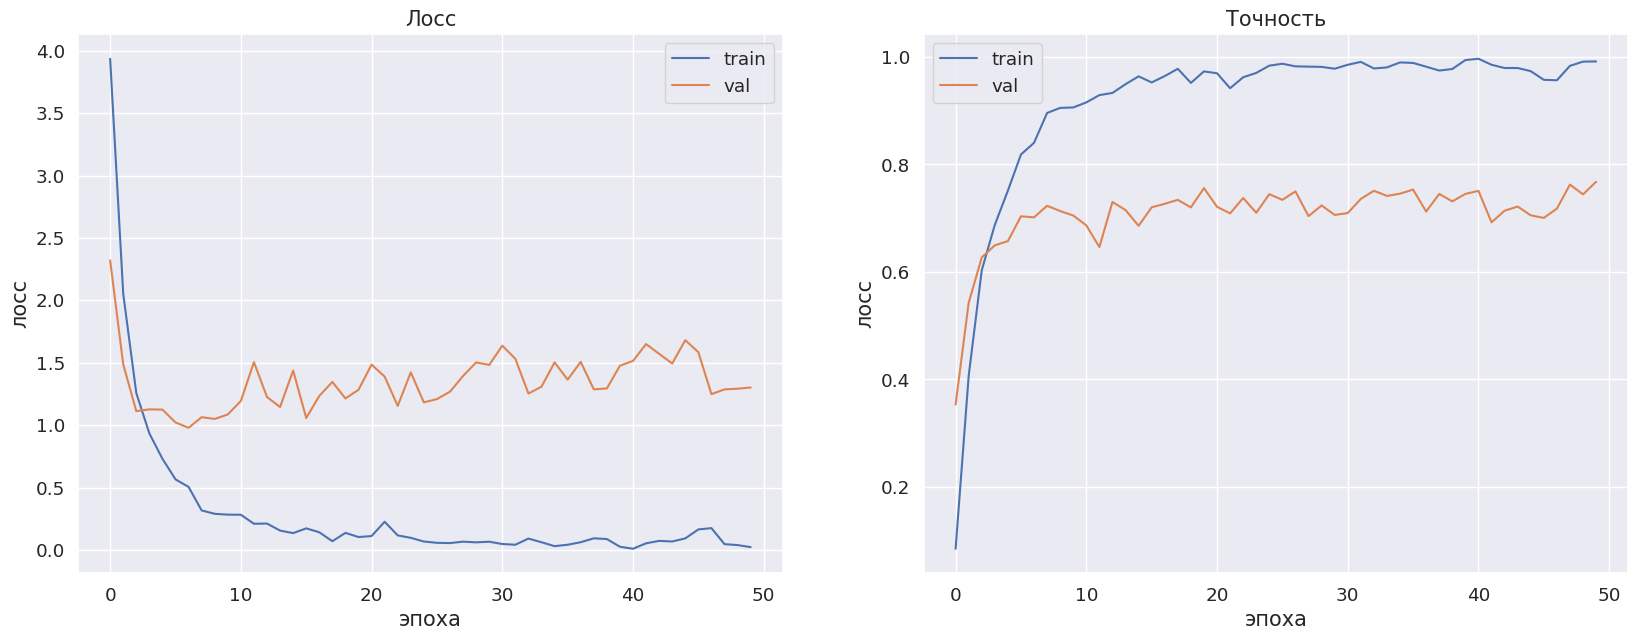

In [ ]:
fine_tuning_model_2 = nn.Sequential()

fine_tuning_model_2.add_module('vgg', vgg16(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
# Add on classifier
fine_tuning_model_2._modules['6'] = nn.Sequential(
                      nn.Linear(in_features=1000, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=87, bias=True)
                      )

fine_tuning_model_2 = fine_tuning_model_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_tuning_model_2.parameters(), lr=0.0001)

clf_model, history = train(
    fine_tuning_model_2, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=50
)


## 2.4 Предобученная сеть VGG16 c добавлением слоев классификации и scheduler StepLR

Epoch 30 of 30 took 42.965s
  training loss (in-iteration): 	0.014082
  validation loss (in-iteration): 	1.136620
  training accuracy: 			99.51 %
  validation accuracy: 			79.63 %


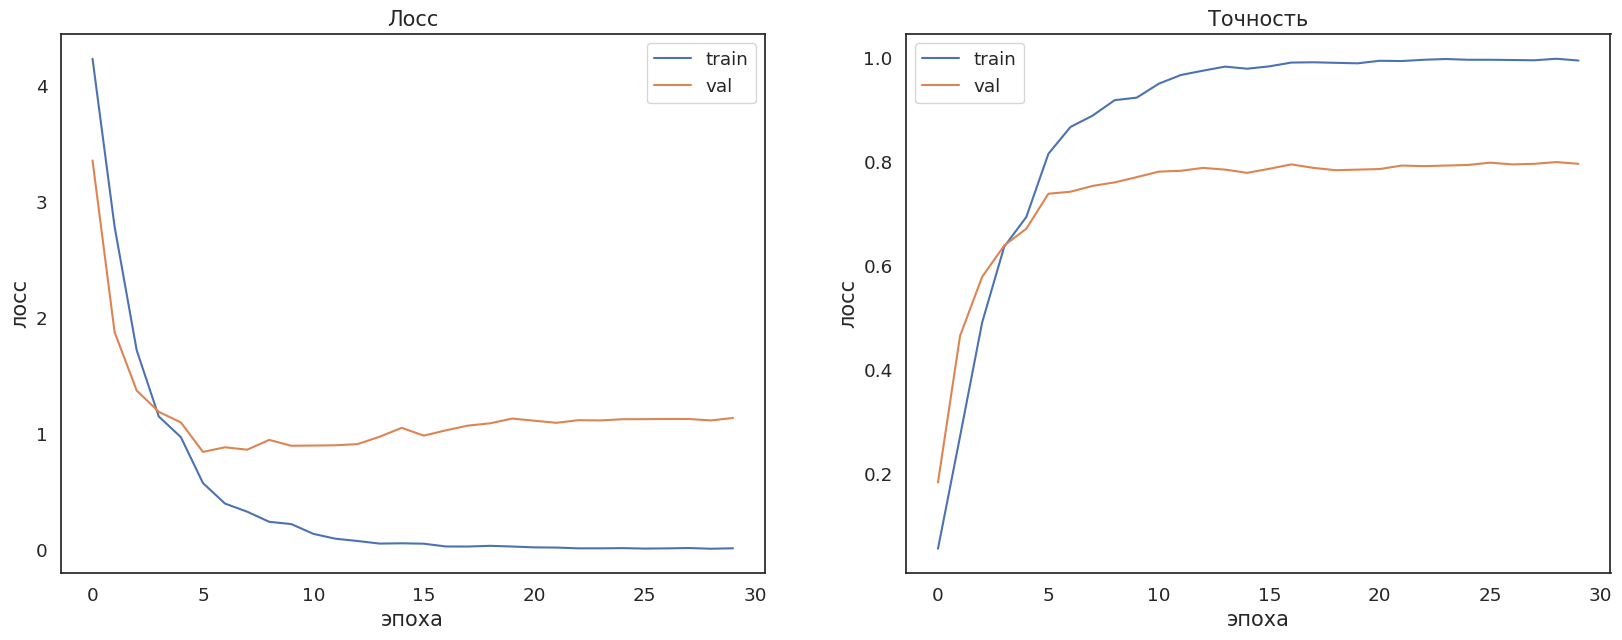

In [ ]:
fine_tuning_model_2_sched_2 = nn.Sequential()

fine_tuning_model_2_sched_2.add_module('vgg', vgg16(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
# Add on classifier
fine_tuning_model_2_sched_2._modules['6'] = nn.Sequential(
                      nn.Linear(in_features=1000, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=87, bias=True)
                      )

fine_tuning_model_2_sched_2 = fine_tuning_model_2_sched_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_tuning_model_2_sched_2.parameters(), lr=0.0001)
# добавим scheduler StepLR для пошаговой снижении скорости обучения
scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

clf_model, history = train(
    fine_tuning_model_2_sched_2, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=30
)


## 2.5 Предобученная модель VGG16 с добавленными слоями классификации и scheduler ExponentialLR

Epoch 30 of 30 took 44.315s
  training loss (in-iteration): 	0.008176
  validation loss (in-iteration): 	1.093568
  training accuracy: 			99.71 %
  validation accuracy: 			78.98 %


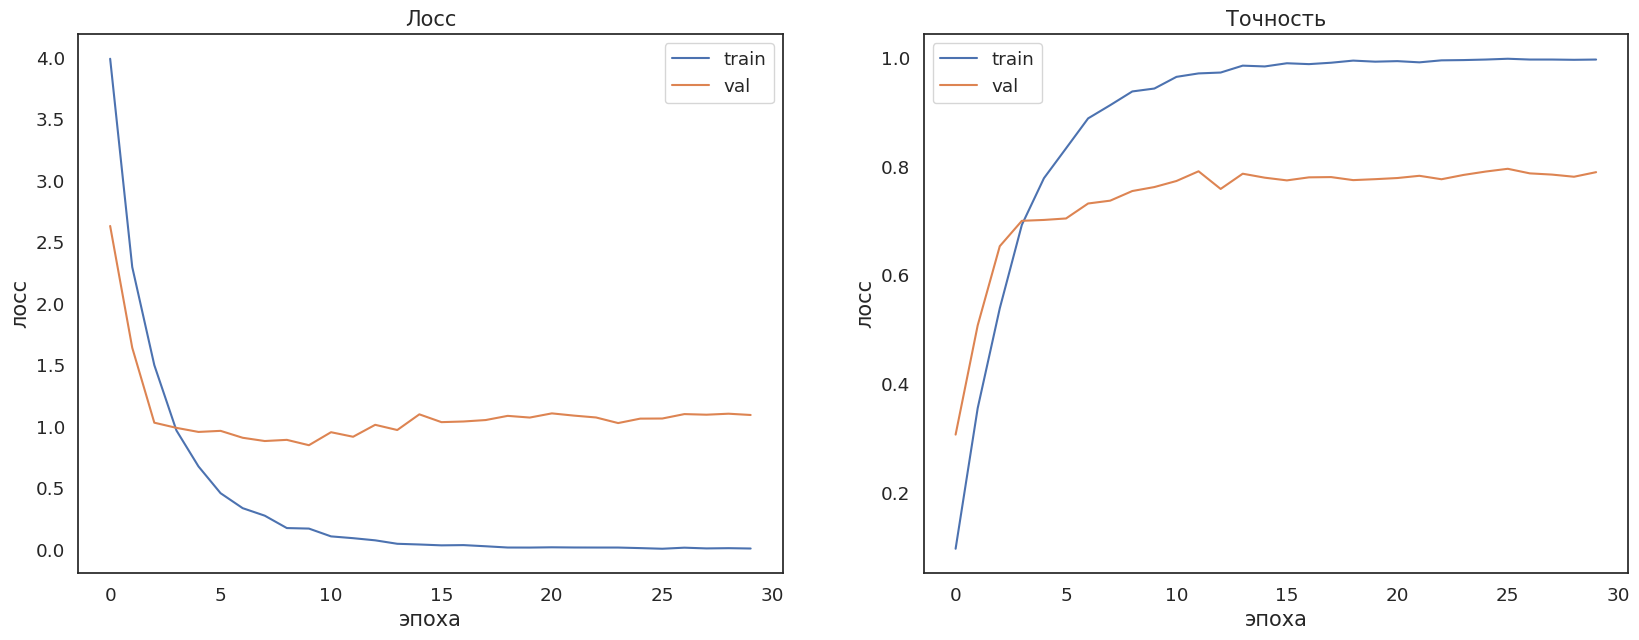

In [ ]:
fine_tuning_model_2_sched = nn.Sequential()

fine_tuning_model_2_sched.add_module('vgg', vgg16(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
# Add on classifier
fine_tuning_model_2_sched._modules['6'] = nn.Sequential(
                      nn.Linear(in_features=1000, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=87, bias=True)
                      )

fine_tuning_model_2_sched = fine_tuning_model_2_sched.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_tuning_model_2_sched.parameters(), lr=0.0001)

# добавим scheduler ExponentialLR для уменьшения скорости обучения каждой группы параметров на гамму в каждую эпоху
scheduler = ExponentialLR(optimizer,
                          gamma = 0.9)

clf_model, history = train(
    fine_tuning_model_2_sched, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    scheduler,
    num_epochs=30
)


# Тестируем модели

In [ ]:
def prediction(images, model):
    xb = (images.unsqueeze(0)).to(device)
    out = model(xb)
    _,preds = torch.max(out, dim=1)
    prediction = train_dataset.classes[preds[0].item()]
    return prediction

In [ ]:
data_dir_1 = "data/test"
data_image_paths_1 = glob.glob(f"{data_dir_1}/*/*.jpg")

print(
    f"Изображений в test: {len(data_image_paths_1)}")

Изображений в test: 363


In [ ]:
input_size = 224

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



test_dataset = torchvision.datasets.ImageFolder(
    data_dir_1,
    transform=test_transform,
    is_valid_file=lambda x: x in data_image_paths_1
)


In [ ]:
print("Количество классов в test ", len(test_dataset.classes))

Количество классов в test  87


# Тестируем модель RESNET18
## (c добавленными слоями и scheduler ExponentialLR)

Label: Amazonite
Prediction: Amazonite


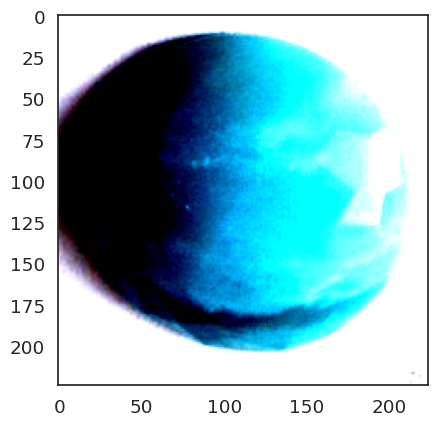

In [ ]:
images, labels = test_dataset[10]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

Label: Bloodstone
Prediction: Bloodstone


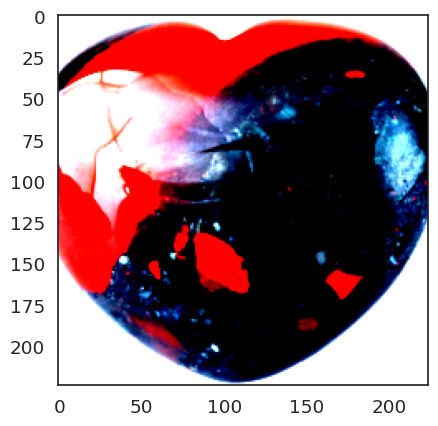

In [ ]:
images, labels = test_dataset[60]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

Label: Zoisite
Prediction: Zoisite


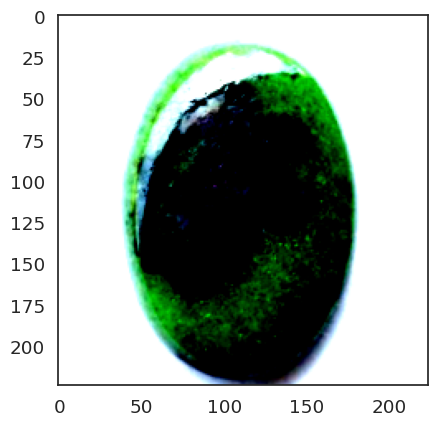

In [ ]:
images, labels = test_dataset[-1]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

Label: Onyx Black
Prediction: Onyx Black


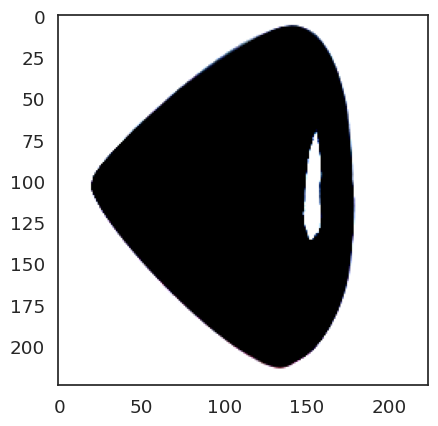

In [ ]:
images, labels = test_dataset[201]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_sched))
plt.imshow(images.permute(1,2,0))

# Тестируем модель VGG16
## (c добавленными слоями и scheduler ExponentialLR)

Label: Amazonite
Prediction: Amazonite


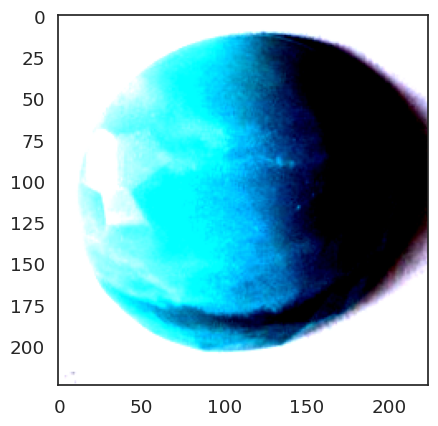

In [ ]:
images, labels = test_dataset[10]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

Label: Alexandrite
Prediction: Alexandrite


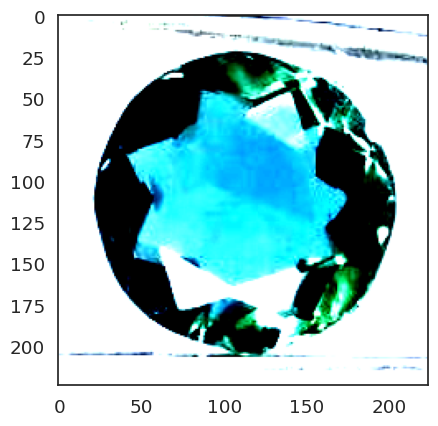

In [ ]:
images, labels = test_dataset[3]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

Label: Zoisite
Prediction: Zoisite


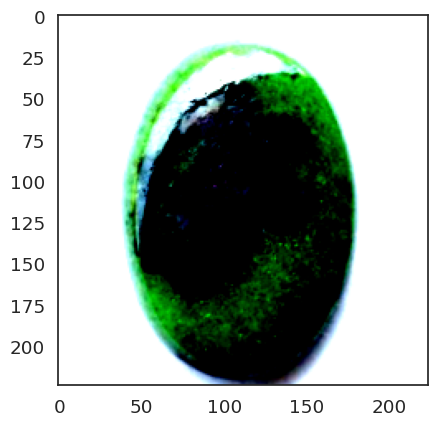

In [ ]:
images, labels = test_dataset[-1]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))

Label: Citrine
Prediction: Citrine


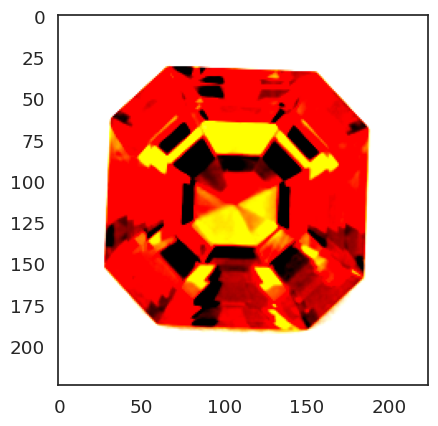

In [ ]:
images, labels = test_dataset[100]
print("Label:", test_dataset.classes[labels])
print("Prediction:", prediction(images, fine_tuning_model_2_sched))
plt.imshow(images.permute(1,2,0))